In [3]:
import numpy as np
import pymc
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from sklearn.linear_model import Lasso

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 1) Bayesian linear Regression

In [4]:
# Define the high-resolution signal
D = 4096 # resolution
t_hr = np.linspace(0, 1, D) # high resolution time grid
x_fct = lambda t: np.cos(29 * 2.0 * np.pi * t) \
+ np.cos(41 * 2.0 * np.pi * t) \
+ np.cos(503 * 2.0 * np.pi * t)
# Nyquist-Shannon: -> 2 * 503 samples / s necessary
x = x_fct(t_hr) # high resolution signal
x_f = np.fft.fft(x)
psd = x_f * x_f.conj() / D # power spectral density

# Get a random subsample of the signal
S = 128
sample_inds = np.random.choice(D, size=S, replace=False)
t_lr = t_hr[sample_inds]
y = x[sample_inds]

# Define DCT matrix
Psi = dct(np.eye(D)) # DCT matrix

# Take random measurements
Phi = Psi[sample_inds, :] # measure rows of Psi

# Equivalently
# C = np.zeros((S, D))
# C[np.arange(S), sample_inds] = 1
# Phi = C @ Psi

# Define a Lasso optimizer and fit
lasso = Lasso(alpha=0.001)
lasso.fit(Phi, y)
theta_star = lasso.coef_ # Lasso best-fit parameters
x_recon = idct(theta_star) # convert from DCT to time domain
x_recon_f = np.fft.fft(x_recon)
psd_recon = x_recon_f * x_recon_f.conj() / D


In [8]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Define true parameters
true_intercept = 1
true_slope = 2

# Generate data
np.random.seed(0)
x_50 = np.linspace(0, 10, 50)
y_50 = true_intercept + true_slope * x_50 + np.random.normal(scale=2, size=len(x_50))

x_1000 = np.linspace(0, 10, 1000)
y_1000 = true_intercept + true_slope * x_1000 + np.random.normal(scale=2, size=len(x_1000))

# Define Bayesian linear regression model
def bayesian_linear_regression(x, y):
    with pm.Model():
        # Priors
        alpha = pm.Normal('alpha', mu=0, tau=1.0 / (10**2))
        beta = pm.Normal('beta', mu=0, tau=1.0 / (10**2))
        sigma = pm.HalfNormal('sigma', tau=1.0 / (1**2))

        # Expected value of outcome
        mu = pm.Deterministic('mu', alpha + beta * x)

        # Likelihood
        likelihood = pm.Normal('y', mu=mu, tau=1.0 / (sigma**2), observed=y)

        # Sample posterior distribution
        trace = pm.sample(20000, burn=1000)

    return trace

# Perform Bayesian linear regression for sample size of 50
trace_50 = bayesian_linear_regression(x_50, y_50)

# Perform Bayesian linear regression for sample size of 1000
trace_1000 = bayesian_linear_regression(x_1000, y_1000)

# Plot posterior samples
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.hist(trace_50['alpha'], bins=30, density=True)
plt.title('Posterior Distribution of Intercept (Sample Size: 50)')

plt.subplot(2, 2, 2)
plt.hist(trace_50['beta'], bins=30, density=True)
plt.title('Posterior Distribution of Slope (Sample Size: 50)')

plt.subplot(2, 2, 3)
plt.hist(trace_1000['alpha'], bins=30, density=True)
plt.title('Posterior Distribution of Intercept (Sample Size: 1000)')

plt.subplot(2, 2, 4)
plt.hist(trace_1000['beta'], bins=30, density=True)
plt.title('Posterior Distribution of Slope (Sample Size: 1000)')

plt.tight_layout()
plt.show()


ValueError: Invalid key found in step_kwargs: {'burn'}. Keys must be step names and values valid kwargs for that stepper. Did you mean {"nuts": {"burn": ...}}?

# 2) Stellar activity 1

a) Load and plot the stellar activity data

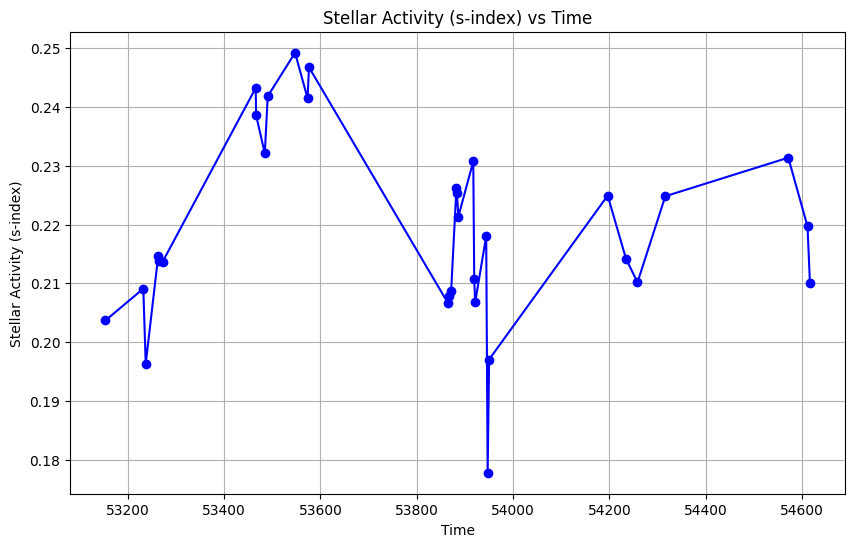

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt('../data/raw_data/HD166724.txt', delimiter=';', skiprows=1, usecols=(2, 3))  # Load columns 2 and 3 (time and s-index)
time = data[:, 0]
activity = data[:, 1]

# Plot data
plt.figure(figsize=(10, 6))
plt.plot(time, activity, marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Stellar Activity (s-index)')
plt.title('Stellar Activity (s-index) vs Time')
plt.grid(True)
plt.show()


b) Choose and explain Kernel: We'll choose the squared exponential kernel for this task. This kernel is commonly used for Gaussian processes due to its smoothness properties and ability to model smooth functions. The squared exponential kernel itself doesn't enforce the requirement for the data to be centered at zero. However, in Gaussian processes, centering the data at zero can be a common preprocessing step to simplify the interpretation of the kernel hyperparameters. When we center the data at zero, we effectively assume that the mean function is zero. This simplifies the interpretation of the kernel hyperparameters because the lengthscale parameter of the squared exponential kernel then directly controls the smoothness of the function, and the variance parameter controls the overall magnitude of the function. So, while the squared exponential kernel doesn't explicitly require the data to be centered at zero, centering the data at zero can often make it easier to interpret and tune the hyperparameters of the kernel, particularly when using Gaussian processes. However, it's not strictly necessary, and the choice depends on the specific context and requirements of the problem.

c) Apply Gaussian Processes and Plot Samples: We use Gaussian processes to draw samples from the posterior distribution using the squared exponential kernel. Then, we'll plot the mean predictions based on the samples.

(d) Explore Hyperparameters Influence: We explore how varying the hyperparameters (σ_f^2 and l) of the squared exponential kernel influences the confidence level of the mean predictions.

<class 'numpy.ndarray'>


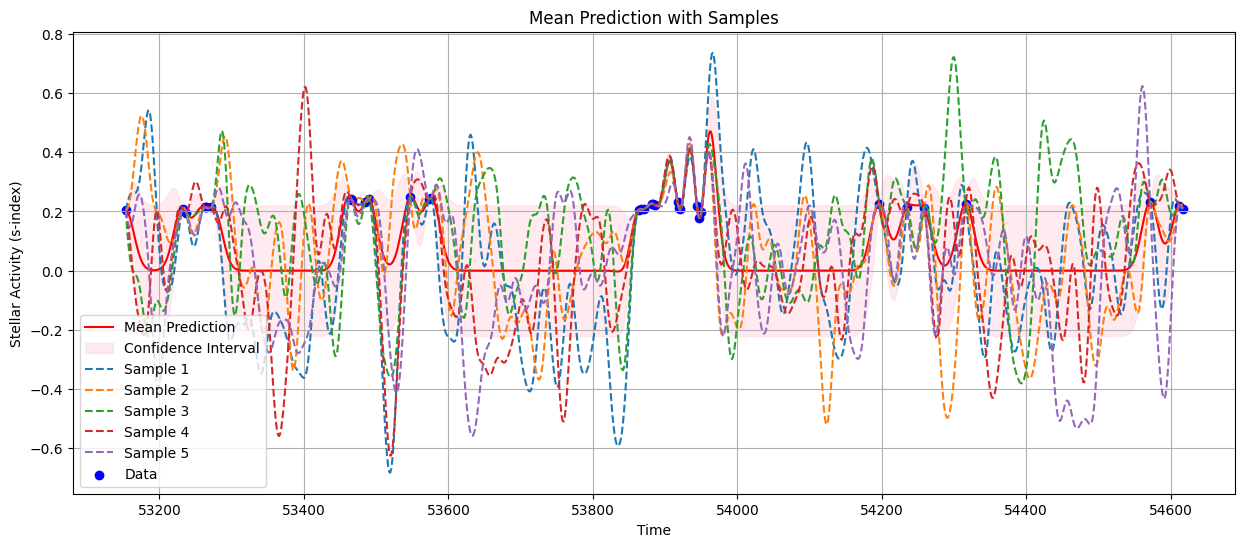

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Define kernel (squared exponential)
kernel = 1.0 * RBF(length_scale=1.0)

# Apply Gaussian process
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(time.reshape(-1, 1), activity)
print(type(time))

# Draw samples from the posterior distribution
n_samples = 5
x_pred = np.linspace(min(time), max(time), 1000).reshape(-1, 1)
y_pred, y_std = gp.predict(x_pred, return_std=True)
samples = gp.sample_y(x_pred, n_samples)

# Plot mean predictions and samples
plt.figure(figsize=(15, 6))
plt.plot(x_pred, y_pred, color='red', label='Mean Prediction')
plt.fill_between(x_pred.ravel(), y_pred - y_std, y_pred + y_std, color='pink', alpha=0.3, label='Confidence Interval')
for i in range(n_samples):
    plt.plot(x_pred, samples[:, i], linestyle='--', label=f'Sample {i+1}')
plt.scatter(time, activity, color='blue', label='Data')
plt.xlabel('Time')
plt.ylabel('Stellar Activity (s-index)')
plt.title('Mean Prediction with Samples')
plt.legend()
plt.grid(True)
plt.show()


# 2) Stellar Activity 2

To analyze the temporal evolution of the Sun's stellar activity and investigate if there's any resemblance to the 11-year sunspot cycle, we'll follow a similar approach as in exercise 2 (a) to (d) but using the "Sun.csv" dataset. 

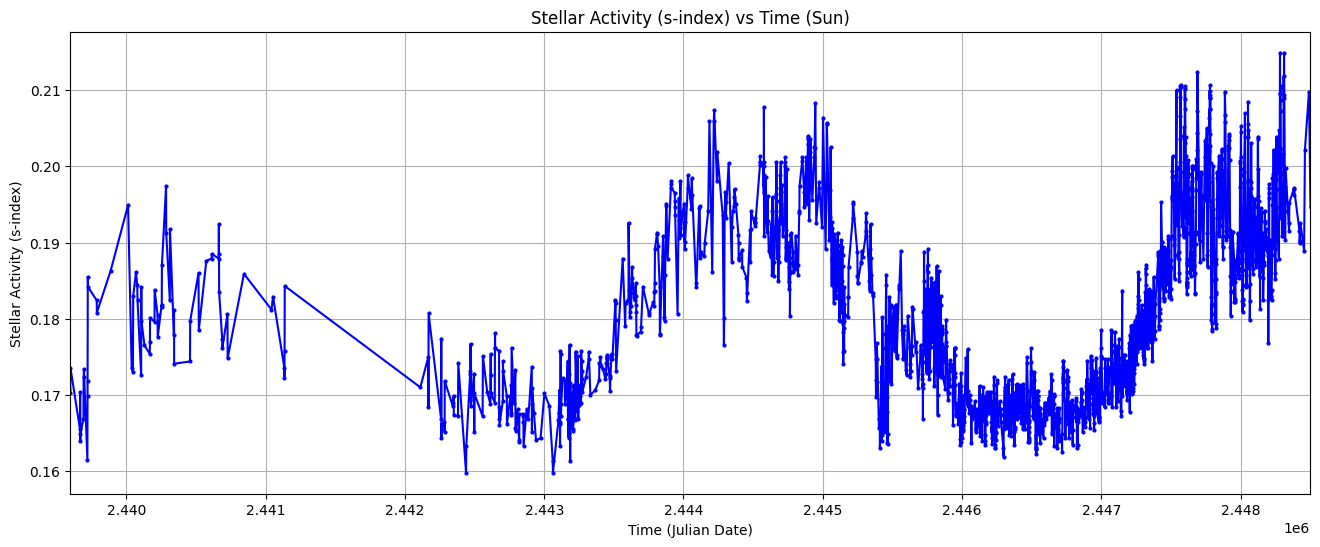

In [12]:
# Load data
data = np.loadtxt('../data/raw_data/Sun.csv', delimiter=',', skiprows=1, dtype=float) 
time = data[:, 0]
activity = data[:, 1]

# Plot data
plt.figure(figsize=(16, 6))
plt.plot(time, activity, marker='o', ms=2, linestyle='-', color='b')
plt.xlabel('Time (Julian Date)')
plt.xlim((2439596,2448500))
plt.ylabel('Stellar Activity (s-index)')
plt.title('Stellar Activity (s-index) vs Time (Sun)')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Define kernel (squared exponential)
kernel = 1.0 * RBF(length_scale=1.0)

print(type(time),type(activity))
# Apply Gaussian process
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(time.reshape(-1, 1), activity)
print(type(time),type(activity))



# Draw samples from the posterior distribution
n_samples = 5
x_pred = np.linspace(min(time), max(time), 1000).reshape(-1, 1)
y_pred, y_std = gp.predict(x_pred, return_std=True)
samples = gp.sample_y(x_pred, n_samples)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


C:\Users\nilse\Documents\projects\DataScience\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [ ]:
# Plot mean predictions and samples
plt.figure(figsize=(15, 6))
plt.plot(x_pred, y_pred, color='red', label='Mean Prediction',alpha=1)
plt.fill_between(x_pred.ravel(), y_pred - y_std, y_pred + y_std, color='pink', alpha=0.5, label='Confidence Interval')
for i in range(n_samples):
    plt.plot(x_pred, samples[:, i], linestyle='--', label=f'Sample {i+1}',alpha=0.5)
plt.scatter(time, activity, color='blue', label='Data')
plt.xlabel('Time')
plt.ylabel('Stellar Activity (s-index)')
plt.title('Mean Prediction with Samples')
plt.legend()
plt.grid(True)
plt.show()




The mean of the posterior distribution in Gaussian Process Regression (GPR) represents the predicted average value of the target variable (in this case, stellar activity or s-index) at each point in time, given the observed data and the learned model.

Regarding the temporal evolution of the data, if the mean of the posterior distribution shows periodic behavior over time, it suggests that there is a pattern or cycle in the data. In the context of solar activity, the 11-year sunspot cycle is a well-known periodic phenomenon. Sunspots are dark spots on the Sun's surface associated with strong magnetic activity, and their numbers vary cyclically over approximately 11 years.

If the mean of the posterior distribution exhibits a similar periodic pattern to the 11-year sunspot cycle, it would indicate that the Gaussian process model has captured the underlying temporal structure in the data, potentially reflecting the periodic nature of solar activity. This resemblance would suggest that the model is effectively capturing the cyclic behavior inherent in the data, similar to the known sunspot cycle.

However, it's important to note that the presence of a periodic pattern in the mean of the posterior distribution doesn't necessarily imply a direct resemblance to the 11-year sunspot cycle. Other factors and phenomena can also contribute to temporal patterns in stellar activity data. Further analysis and comparison with known solar phenomena would be necessary to establish a definitive connection.